(foundations:correctness)=
# Correctness of Symbolic Transitions

A symbolic transition relation relates symbolic inputs to symbolic outputs. Our symbolic interpreter implements a transitive closure over a transition relation consisting of 1-to-n transitions: It takes one symbolic state and produces multiple outputs, resulting in a symbolic execution tree. This leads to an exponential growth of the state space; a common problem in SE. One way to approach this problem is by merging multiple states of the tree, for example after execution of both legs of an `if` statement. Such *state merging* techniques are discussed in {ref}`techniques:state_explosion`. Merging transitions are m-to-1 transitions: Multiple states are combined into one successor. The framework from {cite}`steinhoefel-20*1`, which we present here, goes beyond that and permits m-to-n relations: An arbitrary number of input states can be combined to an arbitrary number of output states.

Formally, an SE transition relation relates a *configuration* $\mathit{Cnf}$, which is a set of symbolic states, to a pair of state sets $(I,O)$, such that $I\subseteq\mathit{Cnf}$ is replaced by $O$ in the *successor configuration*. In a standard SE system, $I$ is always a singleton; for a standard state merging transition, $O$ is a singleton. It is, however, not necessary to incorporate this restriction.

**Definition** (SE Configuration and Transition Relation). An *SE Configuration* is a set $\mathit{Cnf}\subseteq\mathit{SEStates}$. An *SE Transition Relation* is a relation $\delta\subseteq{}2^{\mathit{SEStates}}\times(2^{\mathit{SEStates}}\times2^{\mathit{SEStates}})$ associating to a configuration $\mathit{Cnf}$ transitions $t=(I,O)$ of *input states* $I\subseteq\mathit{Cnf}$ and output states $O\subseteq{}2^{\mathit{SEStates}}$. We call $\mathit{Cnf}\setminus{}I\cup{}O$ the *successor configuration* of the transition $t$ for $\mathit{Cnf}$. We write $\mathit{Cnf}\xrightarrow{t}\mathit{Cnf}'$ if $(\mathit{Cnf}, t)\in\delta$ and $\mathit{Cnf}'$ is the successor configuration of $t$ in $\mathit{Cnf}$.

Note that in this definition, the Cartesian product is not understood as associative: $\delta$ is a *binary relation*, with the power set of symbolic states as domain, and pairs of sets of states as range. Since $\delta$ is a binary relation and no partial function, there might be multiple transitions for each input configuration. This corresponds to different implementations of, e.g., loop execution: There might be a transition based on loop unrolling and one using an invariant approach. Which one to use is a choice made by an SE *strategy*.

 A *big-step SE transition relation* $\delta^\ast$ is the transitive closure of a transition relation $\delta$. In our symbolic interpreter, the `execute_...` methods for the "atomic" statement types like assignment, `if`, etc., implement a transition relation; the methods `execute_stmts` and `execute_block` realize the transitive closure.
 
Based on the previous formalizations, we can define two aspects of the correctness of symbolic transitions. Modulo some details, the literature addressing the semantics of SE {cite}`kneuper-91` {cite}`lucanu.rusu.ea-17` {cite}`boer.bonsangue-19` {cite}`steinhoefel-20*1` agrees that two aspects of SE relations are relevant: First, SE relations can be *underapproximating* because they prune the search space; and second, they can be *overapproximating* because they use coarse abstractions, e.g., for loop and function summaries. In an underapproximation setting, all concrete transitions resulting from concretizing the symbolic ones are *feasible*, which means, e.g., that any bug discovered by symbolic execution corresponds to a real bug that can be triggered by an input. We call this property *precision*. When overapproximating, it is possible that discovered bugs are not feasible. However, one cane be sure that *if* there is a feasible bug, it will be discovered. We call this property of SE relations *exhaustiveness*. An SE relation cannot be exhaustive *and* precise *in general*; however, the execution of programs without loops or recursive calls generally satisfies both property. Furthermore, summarizing loops or methods with the *strongest possible summary* leads to a precise and exhaustive execution. Notwithstanding, finding such a summary can be arbitrarily difficult.

We formally define exhaustive and precise SE transition relations, again following {cite}`steinhoefel-20*1`.

**Definition** (Exhaustive SE Transition Relations). An SE transition relation $\delta\subseteq{}2^{\mathit{SEStates}}\times(2^{\mathit{SEStates}}\times2^{\mathit{SEStates}})$ is called *exhaustive* if, and only if, for each transition $(I, O)$ in the range of $\delta$, $i\in{}I$ and concrete states $\sigma,\sigma'\in\mathit{ConcrStates}$, it holds that $\sigma'\in\mathit{concr}(i,\sigma)$ implies that there is a symbolic state $o\in{}O$ such that $\sigma'\in\mathit{concr}(o,\sigma)$.[^same-init-state]

**Definition** (Precise SE Transition Relations). An SE transition relation $\delta\subseteq{}2^{\mathit{SEStates}}\times(2^{\mathit{SEStates}}\times2^{\mathit{SEStates}})$ is called *precise* if, and only if, for each transition $(I, O)$ in the range of $\delta$, $o\in{}O$ and concrete states $\sigma,\sigma'\in\mathit{ConcrStates}$, it holds that $\sigma'\in\mathit{concr}(o,\sigma)$ implies that there is a symbolic state $i\in{}I$ such that $\sigma'\in\mathit{concr}(i,\sigma)$.

Lemma 3.1 from {cite}`steinhoefel-20*1` asserts that the exhaustiveness / precision of a big-step SE transition relation follows from the exhaustiveness / precision of the underlying single-top transition relation.

Whether we can use an SE system for a specific application scenario, most prominently testing vs. program proving, depends on whether it satisfies the right correctness property. In either case, we want to check whether a program satisfies some property or assertion $\varphi$. Before explaining how the respective properties relate to these application scenarios, we formalize what it means for a symbolic state to satisfy a property. Intuitively, a symbolic state satisfies a property if it holds in all concretizations.

**Definition** (Evaluation of Properties in SESs). Let $s=(\mathit{Constraint},\mathit{Store},\mathit{PC})$ be a symbolic state and $\varphi$ be an assertion (some formula over program variables in $\mathit{PC}$). Then, $\varphi$ does hold in $s$ if, and only if, $\sigma'\in\mathit{concr}(s,\sigma)$ implies that $\varphi$ holds in $\sigma'$, for all $\sigma,\sigma'\in\mathit{ConcrStates}$.

Practically, this definition is useful to check if a formula is violated. Since it is infeasible to examine all concretizations, it is less useful for *proving* that a symbolic state satisfies a property.

Consider the following program which is supposed to invert negative numbers:

In [28]:
x = 0

In [29]:
if x > 1:
    pass
else:
    x = -x

The condition of the `if` statement contains an off-by-one error: It should be `>=` and not `>`. We write a function for applying stores to properties, which we need to use the above definition:

In [30]:
def apply_store(store: Store, formula: z3.BoolRef) -> z3.BoolRef:
    return subst(formula, {var.to_z3(): python_expr_to_z3_expr(value)
                           for var, value in store.env.items()})

We test the property $x\geq{}0$ for a symbolic state with empty store and path condition and the above program as program counter:

In [31]:
x = Variable("x", INT_TYPE)
state = SymbolicEnvironment(SymbolicStore({x: x.to_z3()}))
pc = """
if x > 1:
    pass
else:
    x = -x
"""

x_is_positive = x.to_z3() >= z3.IntVal(0)

for _ in range(100):
    sigma = Store({x: random.randint(-10, 10)})
    sigma_prime = concr(state, pc, sigma)
    satisfies = z3.simplify(apply_store(sigma_prime, x_is_positive))
    if not satisfies:
        print(f"Postcondition {x_is_positive} not satisfied for input x == {sigma['x']}")
        break

Postcondition 0 <= x not satisfied for input x == 1


The code above only finds the bug so quickly since we restricted the range for random inputs to the interval $[-10;10]$. For the still relatively small interval $[-100;100]$, the probability of hitting 1 is already only $201^{-1}\approx{}0.5\%$. For symbolic states with empty program counter $\mathit{PC}$, however, we do *not* have to check all concretizations, and instead create a symbolic assertion that we can pass to z3. The idea is to evaluate the formula $\mathit{Constraint}\rightarrow\{\mathit{Store}\}\varphi$, where $\mathit{Store}\}\varphi$ (the application of $\mathit{Store}$ to $\varphi$) is the formula resulting from replacing all occurrences of left-hand side from $\mathit{Store}$ in $\varphi$ by their right-hand sides in $\mathit{Store}$.

Let us consider the symbolic state arising from the the execution of the inversion in the `else` branch of the `if` statement.

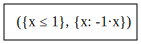

In [32]:
interpreter = SymbolicInterpreter()
tree = interpreter.execute(parse(pc), state)
leaf = get_leaves(tree)[1]
display_set(leaf)

In [33]:
proof_goal = z3.Implies(z3_and(*leaf[0].environment.path_constraints),
                       state.store.apply_to(x_is_positive))
proof_goal

Implies(x <= 1, 0 <= x)

In [34]:
z3.prove(proof_goal)

counterexample
[x = -1]


This indicates how symbolic execution is used in program proving: We execute the full program until we get a set of leaves with empty program counters, and then follow the procedure we just have demonstrated to prove that the desired property holds in those leaves.

To ensure that this leads to valid proofs, the SE transition relation used to obtain the leaves has to be *exhaustive*, as asserted by the below lemma from {cite}`steinhoefel-20*1`:[^simplified-strongly]

**Lemma** (A Property Proven by Exhaustive SE Holds for the Inputs). Let $\delta$ be an exhaustive SE transition relation and $\mathit{Cnf}\xrightarrow{(I,O)}_{\delta^\ast}\mathit{Cnf}'$. If a postcondition $\varphi$ holds for all states $o\in\mathit{Cnf}'$, it follows that $\varphi$ also holds for all $i\in\mathit{Cnf}$.

Intuitively, an exhaustive transition relation does not lose information (in the sense of represented concretizations) along the way, which means that everything we can prove for its outputs must hold for the inputs. Conversely, a violation discovered for an output cannot necessarily be transferred to an input: Discovered bugs might be infeasible for exhaustive SE systems. If feasibility of discovered bugs is a desired goal, symbolic transitions must be *precise*, i.e., not increase the set of represented concretizations during execution.

**Lemma** (A Bug Discovered by Precise SE is Feasible). Let $\delta$ be an precise SE transition relation and $\mathit{Cnf}\xrightarrow{(I,O)}_{\delta^\ast}\mathit{Cnf}'$. If a postcondition $\varphi$ is not true for some state $o\in\mathit{Cnf}'$, it follows that there is an input $i\in\mathit{Cnf}$ such that $\varphi$ does not hold in $i$.

Consequently, symbolic execution must be *precise* if we use if, e.g., in automated testing (fuzzing), and *exhaustive* if we use if for program proving.

Interestingly, the two notions of precision and exhaustiveness can be used as oracles to test the symbolic interpreter! This is, in fact, a new contribution, as we do not know of any existing work on automated testing of symbolic execution engines. To test the interpreter for exhaustiveness, for example, we take an empty symbolic and a random initial concrete state as well as a test program (the program counter), and check that some symbolic output has the same concretization. The precision check is symmetric: We assert that all concretizations for all outputs already exist in the input. Theoretically, we could create not only concrete initial states, but also test programs randomly. However, automatically generating meaningful programs is hard, which is why we use hand-crafted inputs here.

In [35]:
def concr(ses: SymbolicEnvironment,
          pc: Optional[Union[str, ASTNode]],
          sigma: Store) -> Optional[Tuple[Store, Optional[Exception]]]:
    if type(pc) is str:
        pc = parse(pc)

    sigma_1 = ses.concretize(sigma)
    if sigma_1 is None:
        return None

    if pc is None:
        return sigma_1, None

    interpreter = Interpreter()
    environment = Environment(sigma_1)

    exc = None

    try:
        interpreter.execute(pc, environment)
    except Exception as e:
        exc = e

    sigma_2 = environment.store

    return sigma_2, exc

In [36]:
def check_exhaustiveness(interpreter: SymbolicInterpreter,
                         ast_node: ASTNode,
                         input_state: SymbolicEnvironment,
                         sigma: Store) -> bool:
    concr_result_1 = concr(input_state, ast_node, sigma)
    if concr_result_1 is None:
        return True

    sigma_prime, maybe_exc = concr_result_1
    output_states = [node.environment for node, _ in get_leaves(interpreter.execute(ast_node, input_state))]

    for output_state in output_states:
        concr_result_2 = concr(output_state, None, sigma)
        if concr_result_2 is None:
            continue

        sigma_prime_prime, _ = concr_result_2

        if (sigma_prime_prime == sigma_prime and
                (maybe_exc is None or
                 ExceptionWrapper(maybe_exc) ==
                 ExceptionWrapper(output_state.abrupt_completion))):
            return True

    return False

In [37]:
def check_precision(interpreter: SymbolicInterpreter,
                    ast_node: ASTNode,
                    input_state: SymbolicEnvironment,
                    sigma: Store) -> bool:
    output_states = [node.environment for node, _ in get_leaves(interpreter.execute(ast_node, input_state))]

    concr_results_1 = [(output_state, concr_result_1)
                       for output_state, concr_result_1 in [(output_state, concr(output_state, None, sigma))
                                                            for output_state in output_states]
                       if concr_result_1 is not None]
    concr_result_2 = concr(input_state, ast_node, sigma)

    if concr_results_1 and not concr_result_2:
        return False

    for output_state, concr_result_1 in concr_results_1:
        sigma_prime, maybe_exc = concr_result_1
        sigma_prime_prime, _ = concr_result_2

        if (sigma_prime_prime != sigma_prime or
                (maybe_exc is not None and
                 ExceptionWrapper(maybe_exc) !=
                 ExceptionWrapper(output_state.abrupt_completion))):
            return False

    return True

We specialized these checks to transitions with one input and multiple outputs, and also check for equal exceptions if an exception has been raised. Since we implement an automated testing procedure, we can only show the presence of bugs or that a transition is correct with some probability if no problem could be found. The functions `is_probably_exhaustive` and `is_probably_precise` return `None` if not problem with exhaustiveness / precision has been found, and otherwise a concrete store as *counterexample* for an initial assignment for a run where symbolic execution is not exhaustive or not precise.

In [38]:
def is_probably_exhaustive(interpreter: SymbolicInterpreter,
                           variables: Set[Variable],
                           ast_node: ASTNode,
                           num_runs: int = 10,
                           log: bool = False) -> Optional[Store]:
    return is_probably_correct(interpreter, variables, ast_node, True, num_runs, log)


def is_probably_precise(interpreter: SymbolicInterpreter,
                        variables: Set[Variable],
                        ast_node: ASTNode,
                        num_runs: int = 10,
                        log: bool = False) -> Optional[Store]:
    return is_probably_correct(interpreter, variables, ast_node, False, num_runs, log)


def is_probably_correct(interpreter: SymbolicInterpreter,
                        variables: Set[Variable],
                        ast_node: ASTNode,
                        exhaustiveness: bool = True,
                        num_runs: int = 10,
                        log: bool = False) -> Optional[Store]:
    symb_env: Dict[Variable, SymbolicValueType] = {
        variable: variable.to_z3()
        for variable in variables
    }
        
    input_state = SymbolicEnvironment(SymbolicStore(symb_env))
        
    for _ in range(num_runs):
        concr_env: Dict[Variable, Union[int, bool, tuple]] = {
            variable: random_val(variable.type)
            for variable in variables
        }

        sigma = Store(concr_env)

        result = (check_exhaustiveness(interpreter, ast_node, input_state, sigma) if exhaustiveness
                  else check_precision(interpreter, ast_node, input_state, sigma))
        if not result:
            if log:
                print(f"Check for initial state {concr_env}: COUNTEREXAMPLE")
            return sigma
        
        
        if log:
            print(f"Check for initial state {concr_env}: No problem discovered")

    return None


def random_val(t: Type) -> Union[int, bool, tuple]:
    if t == INT_TYPE:
        return random.randint(-100, 100)
    elif t == BOOL_TYPE:
        return random.choice([True, False])
    else:
        return tuple([random.randint(-100, 100) 
                      for _ in range(random.randint(0, 10))])

Now, we can, for example, check wether the implementation of symbolic execution of `if` statements in `SymbolicInterpreter` is precise and exhaustive. As a test program, we choose an `if` statement where the then and else branch each contain a single assignment. We choose relatively expressions for the `if` guard and assignment right-hand sides which can raise different types of exceptions.[^exc-if-found]

In [39]:
if_program = """
if a >= t[a] and g:
    x = a // c
else:
    x = c // b
"""

variables = {
    Variable("a", INT_TYPE),
    Variable("b", INT_TYPE),
    Variable("c", INT_TYPE),
    Variable("g", BOOL_TYPE),
    Variable("t", TUPLE_TYPE),
}

ast_node = parse_on(if_program, "<if_stmt>")

result = is_probably_exhaustive(SymbolicInterpreter(), variables, ast_node)
if not result:
    print("Execution of if statements is probably exhaustive.")
else:
    print(f"Execution of if statements is not exhaustive. Counterexample: {result}")

result = is_probably_precise(SymbolicInterpreter(), variables, ast_node)
if not result:
    print("Execution of if statements is probably precise.")
else:
    print(f"Execution of if statements is not precise. Counterexample: {result}")

Execution of if statements is probably exhaustive.
Execution of if statements is probably precise.


To test the symbolic execution of `while` statements, we choose a relatively simple, but unbounded loop (i.e., the evaluation of the loop guard depends on a symbolic value), and initialize the symbolic interpreter such that loops are unrolled at most two times.

In [40]:
while_program = """
while idx >= x:
    idx = idx - 1
"""

variables = {
    Variable("x", INT_TYPE),
    Variable("idx", INT_TYPE)
}


interpreter = SymbolicInterpreter(loop_unrolling_threshold=2)
ast_node = parse_on(while_program, "<while_stmt>")

result = is_probably_exhaustive(interpreter, variables, ast_node, log=True)
if not result:
    print("Execution of while statements is probably exhaustive.")
else:
    print(f"Execution of while statements is not exhaustive. Counterexample: {result}")

result = is_probably_precise(interpreter, variables, ast_node)
if not result:
    print("Execution of while statements is probably precise.")
else:
    print(f"Execution of while statements is not precise. Counterexample: {result}")

Check for initial state {Variable('idx', Type('int')): 94, Variable('x', Type('int')): 40}: COUNTEREXAMPLE
Execution of while statements is not exhaustive. Counterexample: {idx: 94, x: 40}
Execution of while statements is probably precise.


It turns out the loop unrolling is not exhaustive. This could be expected, since we prune the search space, which leads to a loss of represented concrete states; but now, we have an automatically discovered counterexample! 

In contrast to static analysis techniques like the well-known *Abstract Interpretation* {cite}`cousot.cousot-77`, which reasons in an abstract domain throughout the analysis, symbolic execution is in its nature a *precise analysis technique*. This is reflected by the relatively low effort required to come up with a precise, terminating symbolic interpreter. To render SE *exhaustive*, extra effort needs to be invested (see {ref}`techniques:loops_static_se`).

In subsequent parts of this book, we focus on individual symbolic execution *techniques*, both for exhaustive and precise SE.

## References

```{bibliography}
:filter: docname in docnames
```

[^same-init-state]: We expressed a slightly stricter definition of exhaustiveness than the one given in {cite}`steinhoefel-20*1`. In the original definition, the concrete state $\sigma'$ may be obtained from concretizing $o$ based on a *different* initial state $\sigma''$, which allows consistently renaming variables in right-hand sides. Such a behavior is, however, quite unusual in symbolic execution, which is why we chose to simplify the definition. The same holds for the definition of precision.

[^simplified-strongly]: In {cite}`steinhoefel-20*1`, the definition is a little more involved, since it takes into account uninterpreted logic constants and functions occurring in assertions, for which a strong version of precision and exhaustiveness is required. We only consider assertions over program variables and interpreted functions (such as addition), and possibly quantified formulas with bound logic variables, which permits to simplify the definition.

[^exc-if-found]: We actually found a bug in our symbolic interpreter by testing it using the described methodology. In Python, negative array indices are admissible: `t[-i]`, for positive `i`, is equivalent to `t[len(t)-i`. The symbolic interpreter, however, reported an `IndexError` in a previous version (which is the behavior of `Java`, for instance). By reducing the reported initial state, we quickly discovered the problem. We also discovered a more subtle bug related to Python's semantics: Integer division in Python is a floor division, such that `1 // -2` yields `-1`, while z3 computes `0`. We had to model the Python behavior by replacing `left_val / right_val` by `z3.ToInt(z3.ToReal(left_val) / z3.ToReal(right_val))` in the `handle_binary_operation` method.